In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = max(1, (os.cpu_count() or 1) // 2)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

In [ ]:
class TestImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.jpg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, img_path  # returns image and filename

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_dataset = TestImageFolder(root_dir='./drive/MyDrive/datasets/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def run_inference(model, dataloader, device=None, class_names=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    predictions = []

    with torch.no_grad():
        for imgs, paths in tqdm(dataloader,
                              desc=f"[Test Set]",
                              leave=False):
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            for path, pred, conf in zip(paths, preds, confs):
                pred_idx = pred.item()
                conf_val = conf.item()
                pred_name = class_names[pred_idx] if class_names else str(pred_idx)
                predictions.append({
                    'path': path,
                    'pred_label': pred_idx,
                    'pred_name': pred_name,
                    'confidence': conf_val
                })

    return predictions

In [ ]:
def denormalize(img_tensor):
    img_tensor = img_tensor * IMAGENET_STD + IMAGENET_MEAN
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return img_tensor

In [ ]:
def plot_image(prediction):
  img = Image.open(prediction['path']).convert('RGB')

  plt.imshow(img)
  plt.title(f"Predicted: {prediction['pred_name']}, Confidence: {prediction['confidence']}")
  plt.show()

## TinyVGG Classification on Test Set

In [ ]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(TinyVGG, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 112x112
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 56x56
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 28x28
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # -> 14x14
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tinyVGG = TinyVGG(num_classes=2).to(device)

In [ ]:
checkpoint = torch.load('./drive/MyDrive/dl/TinyVGG-val-0.9220.pth', map_location='cpu')

tinyVGG.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
tinyvgg_predictions = run_inference(tinyVGG, test_loader, device, ['cat', 'dog'])

In [ ]:
tinyvgg_unsure_predictions = []

for prediction in tinyvgg_predictions:
  if prediction['confidence'] < 0.6:
    tinyvgg_unsure_predictions.append(prediction)

In [ ]:
len(tinyvgg_unsure_predictions)

28

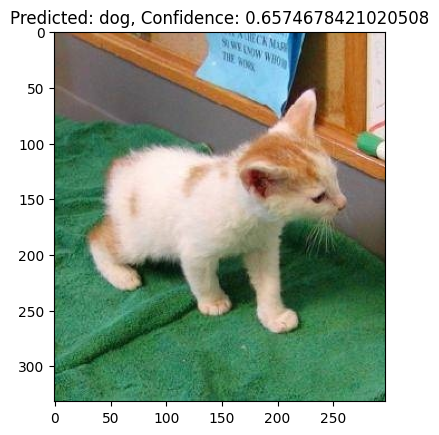

In [ ]:
plot_image(tinyvgg_predictions[21])

## Transfer Learning on Test Set

In [ ]:
from torchvision.models import ResNet34_Weights, resnet34

def build_feature_extractor(num_classes: int) -> nn.Module:
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = resnet34(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_feature_extractor(num_classes=2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 144MB/s]


In [ ]:
!pip install -q torchinfo

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [ ]:
weights = torch.load('./drive/MyDrive/dl/resnet.pth', map_location='cpu')

model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
predictions = run_inference(model, test_loader, device, ['cat', 'dog'])

In [ ]:
unsure_predictions = []

for prediction in predictions:
  if prediction['confidence'] < 0.6:
    unsure_predictions.append(prediction)

In [ ]:
unsure_predictions

[{'path': './drive/MyDrive/datasets/test/47.jpg',
  'pred_label': 0,
  'pred_name': 'cat',
  'confidence': 0.5388150811195374},
 {'path': './drive/MyDrive/datasets/test/293.jpg',
  'pred_label': 0,
  'pred_name': 'cat',
  'confidence': 0.5013522505760193}]

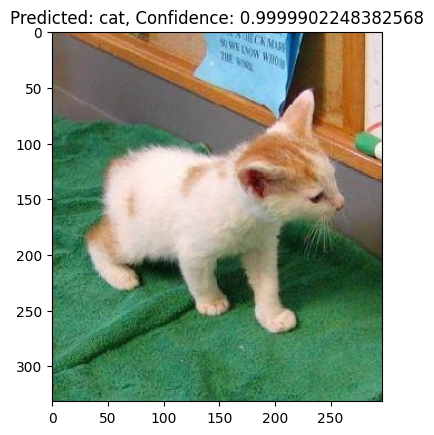

In [ ]:
plot_image(predictions[21])